<b> <font size="6"> SOLUTION DETAILS (LOGIC)<font size="6"> </b>
    
<font size="4"> There are multiple factors influencing the price of a stock including historical stock prices and news of interest. So, in order to forecast a price accurately, both Time-Series data and news of interest is considered as an input data sources. <font size="4"> 
    
<b><font size="4"> STEP 1 - Predict Stock Price changes for next 5 mins basis Stock Price Time-Series (Vector Autoregression) !


<font size="4"> STEP 2 - Predict Stock Price changes for next 5 mins basis Twitter News (NLP and Regression) !
    
    
<font size="4"> STEP 3 - Compute weightage Average of Step 1 and Step 2 as final stock price for next 5 mins !</b>
    
STEP 1 and STEP 2 can be combined into one STEP using LSTM Regressor. However, due to limited dataset, neural network will not make sense. In real time, implementation - It will be interesting to measure LSTM along with many other algorithms and approaches!




<b> <font size="4">Importing Libraries


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import datetime as dt
from sklearn.preprocessing import StandardScaler
import pandas_datareader.data as web
import math
from pyspark.sql import SparkSession
from pyspark import SparkConf,SparkContext
from pyspark.sql import SQLContext,functions as F
from pyspark.sql.types import *
import nltk




<b> <font size="4">Using Spark to load the datasets because in real time project implementation, python will not be effective to load huge data set comprising of financial and tweets data. Spark provides high computer with Parallel computation


<b> <font size="4">This will run on GCP Spark DataProc or AWS EMR Spark cluster

In [3]:
spark = SparkSession \
            .builder \
            .appName('Stock Market Prediction') \
            .config('spark.driver.memory', '5g') \
            .config('spark.executor.memory', '5g') \
            .config("spark.executor.cores",1) \
            .config('spark.executor.heartbeatInterval","7200s') \
            .config('spark.sql.inMemoryColumnarStorage.compressed',True) \
            .config('spark.sql.broadcastTimeout',"36000") \
            .getOrCreate()

<b><font size="4"> STEP 1 BEGINS

<b> <font size="4">Loading Financial Data into spark dataframe

In [4]:
df_spark_f= spark.read.format("csv") \
                     .option("header", "true") \
                     .option("delimiter", ",") \
                     .load("financial_data.csv") 


<b> <font size="4">Alternatively, one can load directly in pandas for simplicity

In [5]:
import pandas as pd
df_pd = pd.read_csv('financial_data.csv')


<b> <font size="4">Get Shape


In [6]:
df_pd.shape

(1910, 6)

<b> <font size="4">Get STATS

In [7]:
df_pd.describe()

,openBAC,openMA,openAAPL,openPFE,openBYND
count,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000
mean,30.319276,276.163921,210.681070,39.313202,195.250437
std,0.654056,4.821312,5.005540,1.496761,17.180351
min,28.915000,265.710000,201.700000,37.695000,172.096200
25%,29.610000,273.042500,207.931125,38.180000,177.741250
50%,30.640000,277.060000,209.880000,38.935000,197.800000
75%,30.785000,280.750000,216.437500,39.513750,205.403025
max,31.045000,283.120000,221.290000,42.930000,233.163600


In [8]:
df_pd.columns

Index(['openBAC', 'openMA', 'openAAPL', 'openPFE', 'openBYND', 'timestamp'], dtype='object')

<b> <font size="4">View Data

In [9]:
df_pd.head(10)

,openBAC,openMA,openAAPL,openPFE,openBYND,timestamp
0,29.350,269.5300,203.6500,37.940,177.4909,2019-08-02 16:00
1,29.375,269.6400,203.6500,37.960,177.4000,2019-08-02 15:59
2,29.390,269.8800,203.7800,37.990,177.5250,2019-08-02 15:58
3,29.350,269.8000,203.7700,37.990,177.5100,2019-08-02 15:57
4,29.285,269.3300,203.2900,37.940,177.7100,2019-08-02 15:56
5,29.320,269.2500,203.3500,37.935,177.6500,2019-08-02 15:55
6,29.355,269.4914,203.3500,37.980,177.5000,2019-08-02 15:54
7,29.365,269.5300,203.5338,37.995,177.8300,2019-08-02 15:53
8,29.380,269.5400,203.4400,38.000,178.1548,2019-08-02 15:52
9,29.410,269.6800,203.5611,38.025,177.9500,2019-08-02 15:51


<b> <font size="4">Remove TimeStamp as there is a clear time interval ( 1 min) in data

In [10]:
df_pd= df_pd.drop(['timestamp'], axis=1)


<b> <font size="4"> Visualize price fluctuations

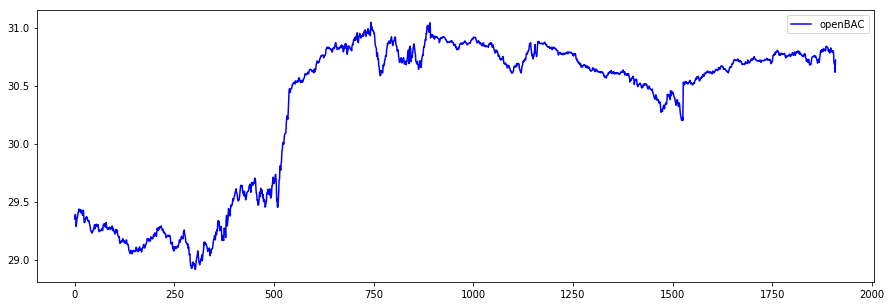

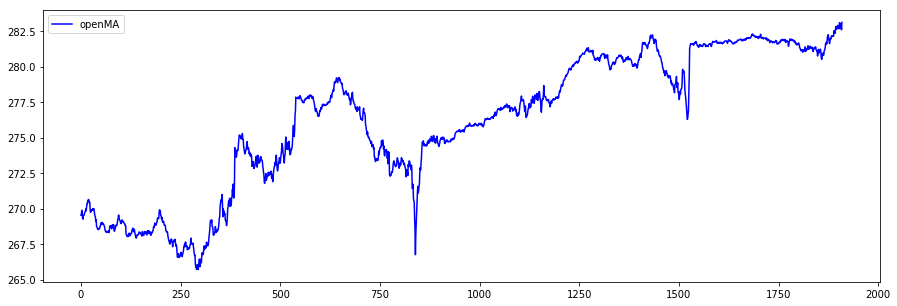

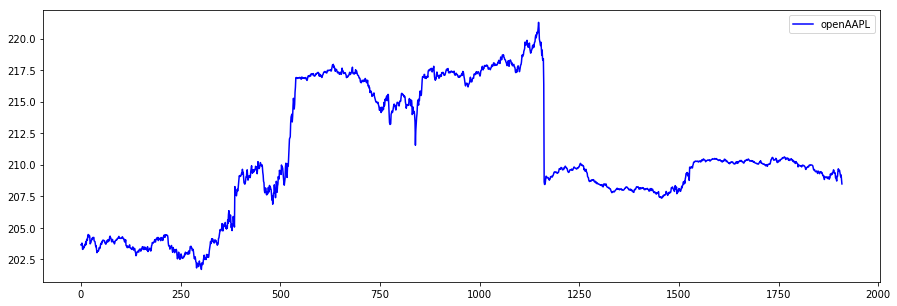

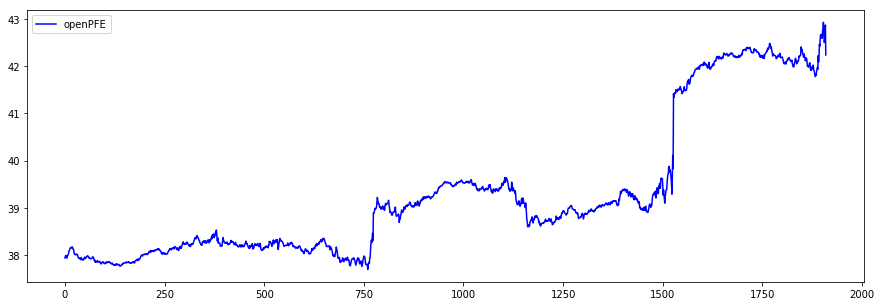

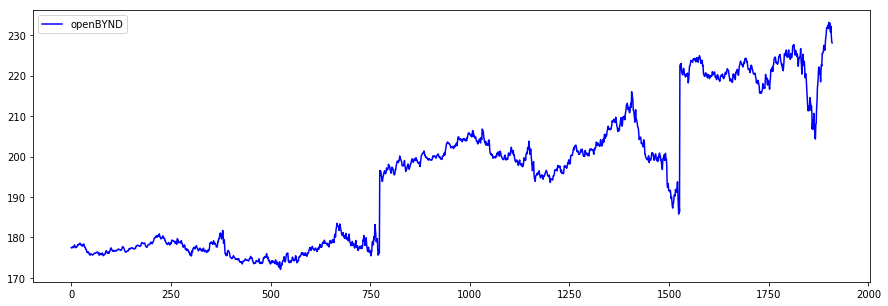

In [11]:
for i in df_pd.columns:
    plt.figure(figsize=(15,5))
    plt.plot(df_pd[i], color='blue', label=i)
    plt.legend(loc='best')
    plt.show()

<b> <font size="4"> Convert dataframe to Array

In [12]:
df= np.asarray(df_pd)

<b> <font size="4"> Train/Validate Split

In [13]:
train = df[:int(0.8*(len(df)))]
valid = df[int(0.8*(len(df))):]

In [14]:
train.shape, valid.shape

((1528, 5), (382, 5))

<b> <font size="4"> Model Training and Prediction.
    
Due to limited data set, it makes sense to use a simple model - Autoregression

In [15]:
from statsmodels.tsa.vector_ar.var_model import VAR

var = VAR(endog=train)

model = var.fit()


In [16]:
prediction = model.forecast(model.y, steps=5)
prediction

array([[ 30.5348169 , 281.37937005, 209.94734208,  41.45410493,
        223.38100687],
       [ 30.53964911, 281.4882259 , 210.08480231,  41.4875852 ,
        224.18548446],
       [ 30.544497  , 281.59657861, 210.21993385,  41.52045576,
        224.97383239],
       [ 30.54936094, 281.70443899, 210.35278868,  41.55273119,
        225.74644115],
       [ 30.55424126, 281.81181762, 210.48341757,  41.58442576,
        226.50369229]])

In [17]:
pred = pd.DataFrame(prediction, columns=('openBAC','openMA','openAAPL','openPFE','openBYND'))

pred.head(2)


,openBAC,openMA,openAAPL,openPFE,openBYND
0,30.534817,281.379370,209.947342,41.454105,223.381007
1,30.539649,281.488226,210.084802,41.487585,224.185484


<b> <font size="4">Validate/test the model predictions


In [18]:
valid_prediction = model.forecast(valid, steps=len(valid))
valid_prediction


array([[ 30.72613471, 283.27789591, 208.70428067,  42.29508606,
        229.44337433],
       [ 30.73228473, 283.43489332, 208.92448211,  42.34909016,
        230.77204972],
       [ 30.7384508 , 283.59101114, 209.14069569,  42.40203792,
        232.07271293],
       ...,
       [ 34.32203932, 331.65748551, 230.83936059,  50.09867029,
        387.99867072],
       [ 34.33334796, 331.80464507, 230.87486845,  50.12442333,
        388.47448253],
       [ 34.34466682, 331.95205796, 230.91041133,  50.15024391,
        388.95142872]])

<b><font size="5"> Performance Metrics

<b><font size="4"> Average Absolute Error

In [19]:
step1_errors = abs(valid_prediction - valid)
print('Average absolute error:', round(np.mean(step1_errors), 2), 'degrees.')


Average absolute error: 28.19 degrees.


<b><font size="4"> Accuracy

In [20]:
step1_mape = 100 * (step1_errors / valid)
step1_acc = 100 - np.mean(step1_mape)
print('Accuracy:', round(step1_acc, 2), '%')

Accuracy: 85.09 %


In [21]:
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 11, Oct, 2019
Time:                     14:44:01
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -19.0339
Nobs:                     1527.00    HQIC:                  -19.0996
Log likelihood:           3808.75    FPE:                4.87750e-09
AIC:                     -19.1386    Det(Omega_mle):     4.78280e-09
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.175531         0.089104           -1.970           0.049
L1.y1         0.994507         0.003118          318.950           0.000
L1.y2         0.000506         0.000260            1.951           0.051
L1.y3         0.000429

In [22]:
def visualize_results():
    bac=[]
    bac_predicted=[]
    for i in range(0, len(valid)):
        bac.append(valid[i][3])
        bac_predicted.append(valid_prediction[i][3])

    plt.figure(figsize=(21,7))
    plt.plot(bac,label='Price',color='blue')
    plt.plot(bac_predicted,label='Predicted',color='red')
    plt.title('Price vs Predicted')
    plt.legend(loc='upper left')
    plt.show()
    return 1
    

<b> <font size="4"> STOCK PRICE FOR NEXT 5 MINUTES BASIS "Autoregression model"


In [23]:
#Input (current prices)
new_data = np.array([(30.72,283.12,208.48,42.24,228.086)])
prediction_new = model.forecast(new_data, steps=5)
print("Predicted price at 5 mins Intervals: ")
print(prediction_new)

Predicted price at 5 mins Intervals: 
[[ 30.72613471 283.27789591 208.70428067  42.29508606 229.44337433]
 [ 30.73228473 283.43489332 208.92448211  42.34909016 230.77204972]
 [ 30.7384508  283.59101114 209.14069569  42.40203792 232.07271293]
 [ 30.74463363 283.74626788 209.35301071  42.45395438 233.34603507]
 [ 30.75083392 283.90068162 209.56151444  42.50486401 234.5926719 ]]


<b><font size="4"> STEP 1 ENDS

<b><font size="4"> STEP 2 BEGINS

<b> <font size="4">Loading twitter feed into spark dataframe


<b> <font size="4">Alternatively, one can load directly in pandas for simplicity and convert to spark dataframe later if needed.</b>

In [24]:
import pandas as pd
df = pd.read_csv('twitterfeed.csv')

df_spark = spark.createDataFrame(df)

<b> <font size="4"> Number of records in twitter file

In [25]:
df_spark.count()

3006

<b> <font size="4"> Check data schema

In [26]:
df_spark.printSchema()

root
 |-- Screen Name: string (nullable = true)
 |-- User Name: string (nullable = true)
 |-- Tweet Created At: string (nullable = true)
 |-- Tweet Text: string (nullable = true)
 |-- Tweet Coordinates: string (nullable = true)
 |-- Retweet Count: long (nullable = true)
 |-- Phone Type: string (nullable = true)
 |-- Favorite Count: long (nullable = true)
 |-- Favorited: boolean (nullable = true)
 |-- Type: string (nullable = true)



<b> <font size="4"> View Data

In [27]:
df_spark.show(5, truncate=20)

+-----------+---------+----------------+--------------------+-----------------+-------------+--------------------+--------------+---------+--------------------+
|Screen Name|User Name|Tweet Created At|          Tweet Text|Tweet Coordinates|Retweet Count|          Phone Type|Favorite Count|Favorited|                Type|
+-----------+---------+----------------+--------------------+-----------------+-------------+--------------------+--------------+---------+--------------------+
|       CNBC|     CNBC|2019-08-02 22:42|Liz Dunn, founder...|             None|            5|Twitter Media Studio|             6|    false|from:cnbc -filter...|
|       CNBC|     CNBC|2019-08-02 22:14|The @SquawkCNBC c...|             None|            1|Twitter Media Studio|             7|    false|from:cnbc -filter...|
|       CNBC|     CNBC|2019-08-02 22:12|This one phrase c...|             None|            4|          SocialFlow|            19|    false|from:cnbc -filter...|
|       CNBC|     CNBC|2019-08-02 

<b> <font size="4"> View STATS

In [28]:
df_spark.describe().show(10, truncate=10)

+-------+-----------+----------+----------------+----------+-----------------+-------------+----------+--------------+----------+
|summary|Screen Name| User Name|Tweet Created At|Tweet Text|Tweet Coordinates|Retweet Count|Phone Type|Favorite Count|      Type|
+-------+-----------+----------+----------------+----------+-----------------+-------------+----------+--------------+----------+
|  count|       3006|      3006|            3006|      3006|             3006|         3006|      3006|          3006|      3006|
|   mean|       null|      null|            null|      null|             null|   13.4411...|      null|    27.9614...|      null|
| stddev|       null|      null|            null|      null|             null|   181.392...|      null|    469.045...|      null|
|    min|   Benzinga|  Benzinga|      2019-07...|"...the...|             None|            0|Hootsui...|             0|from:IB...|
|    max| nytimes...|WSJ Mar...|      2019-08...|⚡️ “Pow...|             None|         968

<b> <font size="4"> Register Spark Data Frame as Table to perform SQL Operations

In [29]:
df_spark.registerTempTable("spark_tbl")

<b> <font size="5"> Analyze features

<b> <font size="4"> Feature- Screen Name

In [30]:
spark.sql('''select `Screen Name`,  count (1)
              from spark_tbl
              group by 1
              order by 2 desc
              ''').show(50, False)

+---------------+--------+
|Screen Name    |count(1)|
+---------------+--------+
|CNBC           |1662    |
|nytimesbusiness|590     |
|Benzinga       |241     |
|WSJmarkets     |203     |
|bespokeinvest  |109     |
|IBDinvestors   |88      |
|Stocktwits     |69      |
|BreakoutStocks |44      |
+---------------+--------+



<b> <font size="4"> Looks like CNBC is the most common screen name which is 50% of the data.
    So this feature can be ignore other wise dataset will become imbalanced. Similar is the case with User Name as shown below

In [31]:
spark.sql('''select `User Name`,  count (1)
              from spark_tbl
              group by 1
              order by 2 desc
              ''').show(100, False)

+-------------------+--------+
|User Name          |count(1)|
+-------------------+--------+
|CNBC               |1662    |
|NYT Business       |590     |
|Benzinga           |241     |
|WSJ Markets        |203     |
|Bespoke            |109     |
|Investors.com      |88      |
|Stocktwits         |69      |
|Top Breakout Stocks|44      |
+-------------------+--------+



<b> <font size="2">Tweet feature is null so ignore it

In [32]:
spark.sql('''select `Tweet Coordinates`,  count (1)
              from spark_tbl
              group by 1
              order by 1 asc
              ''').show(100, False)


+-----------------+--------+
|Tweet Coordinates|count(1)|
+-----------------+--------+
|None             |3006    |
+-----------------+--------+



<b> <font size="4"> Correlation among Numeric Features

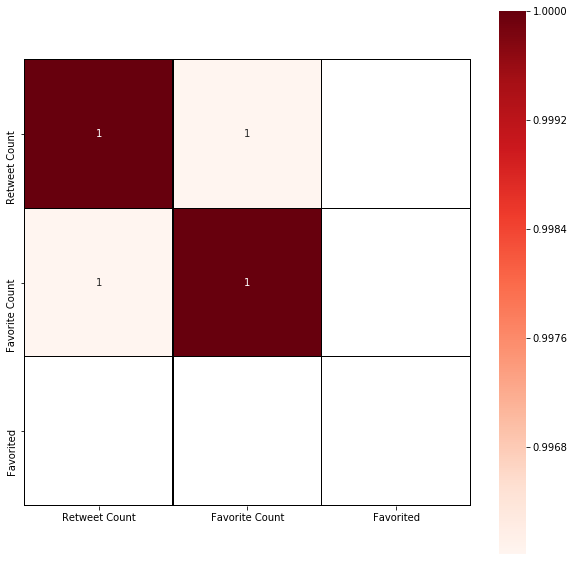

In [33]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), square=True, annot=True, cmap='Reds',linecolor="black", linewidths=0.20)
plt.show()

<b> <font size="4"> Feature - Retweet Count

In [34]:
df_retweet=spark.sql('''select `Retweet Count`,  count (1) as count
              from spark_tbl
              group by 1
              order by 1 asc
              ''')
df_retweet.show()

+-------------+-----+
|Retweet Count|count|
+-------------+-----+
|            0|  176|
|            1|  299|
|            2|  304|
|            3|  308|
|            4|  267|
|            5|  221|
|            6|  179|
|            7|  155|
|            8|  147|
|            9|  129|
|           10|   97|
|           11|   61|
|           12|   62|
|           13|   74|
|           14|   48|
|           15|   48|
|           16|   51|
|           17|   33|
|           18|   28|
|           19|   26|
+-------------+-----+
only showing top 20 rows



In [35]:
df_retweet=df_retweet.toPandas()

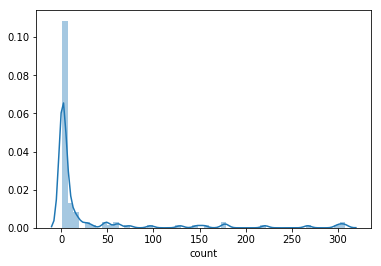

In [36]:
sns.distplot(df_retweet['count'])
plt.show()

/Users/jatinmalhotra/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


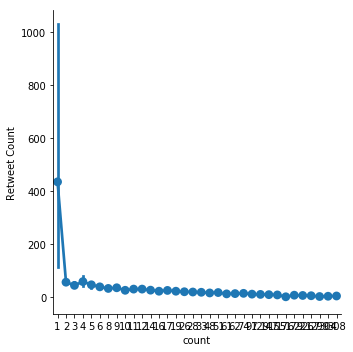

In [37]:
sns.factorplot(x="count",y="Retweet Count",data=df_retweet)
plt.show()

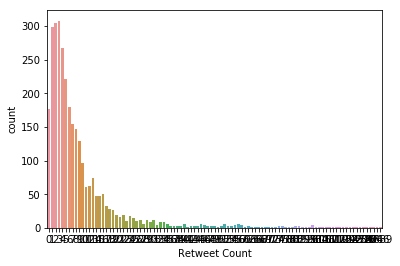

In [38]:
sns.barplot(x="Retweet Count",y="count",data=df_retweet)
plt.show()

<b> <font size="4"> Feature - Favorite Count

In [39]:
df_favorite=spark.sql('''select `Favorite Count`,  count (1) as count
              from spark_tbl
              group by 1
              order by 1 asc
              ''')
df_favorite.show()

+--------------+-----+
|Favorite Count|count|
+--------------+-----+
|             0|  182|
|             1|  244|
|             2|  216|
|             3|  182|
|             4|  152|
|             5|  143|
|             6|  101|
|             7|  113|
|             8|   98|
|             9|   97|
|            10|   92|
|            11|   74|
|            12|   90|
|            13|   88|
|            14|   94|
|            15|   49|
|            16|   60|
|            17|   56|
|            18|   49|
|            19|   47|
+--------------+-----+
only showing top 20 rows



In [40]:
df_favorite=df_favorite.toPandas()

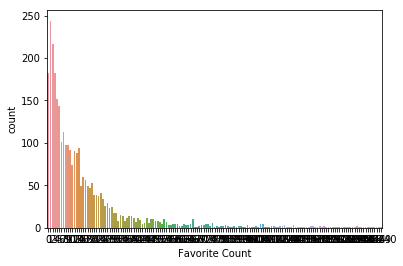

In [41]:
sns.barplot(x="Favorite Count",y="count",data=df_favorite)
plt.show()

<b> <font size="4"> Feature - Tweet Created At

In [42]:
df_created=spark.sql('''select `Tweet Created At`,  count (1) as count
              from spark_tbl
              group by 1
              order by 2 desc
              ''')
df_created.show()

+----------------+-----+
|Tweet Created At|count|
+----------------+-----+
|2019-08-02 19:33|    7|
|2019-07-30 13:03|    6|
|2019-07-31 18:01|    5|
|2019-08-01 19:50|    5|
|2019-08-01 14:47|    5|
|2019-07-30 20:34|    4|
|2019-07-30 11:02|    4|
|2019-07-24 14:01|    4|
|2019-08-02 12:32|    4|
|2019-07-25 20:08|    4|
|2019-07-30 20:21|    4|
|2019-07-30 20:55|    4|
|2019-08-01 20:02|    4|
|2019-07-28 13:02|    4|
|2019-07-26 17:47|    4|
|2019-07-26 12:31|    4|
|2019-08-01 11:01|    4|
|2019-08-02 16:05|    3|
|2019-08-01 13:49|    3|
|2019-07-29 20:02|    3|
+----------------+-----+
only showing top 20 rows



<b> <font size="4"> Get important features only. Remove Rest

In [43]:
df=spark.sql('''select CAST(`Tweet Created At` AS timestamp) as tweet_created_at,
                        `Tweet Text` as tweet_text,
                        `Retweet Count` as retweet_count,
                        `Favorite Count` as favorite_count
                         from spark_tbl
                          ''')
df.show()


+-------------------+--------------------+-------------+--------------+
|   tweet_created_at|          tweet_text|retweet_count|favorite_count|
+-------------------+--------------------+-------------+--------------+
|2019-08-02 22:42:00|Liz Dunn, founder...|            5|             6|
|2019-08-02 22:14:00|The @SquawkCNBC c...|            1|             7|
|2019-08-02 22:12:00|This one phrase c...|            4|            19|
|2019-08-02 21:43:00|CNBC's @onlyyoont...|            6|            14|
|2019-08-02 21:27:00|Johnson &amp; Joh...|            8|             6|
|2019-08-02 21:12:00|Kathryn Thompson,...|            3|            11|
|2019-08-02 20:36:00|Eli Lilly confirm...|            8|            17|
|2019-08-02 20:22:00|Nobel Prize winni...|           27|            51|
|2019-08-02 20:09:00|Perfect storm bui...|            7|            15|
|2019-08-02 20:03:00|All 3 major U.S. ...|           16|            22|
|2019-08-02 20:02:00|Why are some peop...|            3|        

<b> <font size="4"> Register dataframe as sql data

In [44]:
df.registerTempTable("spark_tbl")

<b> <font size="4">In Real Project Implementation, A NLP Sentiments Analysis model will need to be developed using labelled historical news of interest. In other words, following will be the data requirements:-</b> 


<font size="3">
1) Collect all historical news related to either stock itself or the industry stock belongs to and label the news as positive or negative or neutral. (it would be great to have polarity score as well, which means how much % is the news positive or negative or neutral). This needs to be done manually using domain expertised knowledge.


2) Develop a NLP sentiment analysis model which will learn from above training data to be able to classify future news content.

For the purpose of this test, I am using a combination of TextBlob and Vader libraries to classify the news content since there is no news training data given (Twitter news data is not labelled. hence cannot be used for training). 

These two libraries are pre-trained sentiment analysis models. If I do not use this library then I will have to create a labelled twitter news data manually and then trained a model which will be very time consuming and out of the scope of this project.


<b> <font size="4"> Use NLTK Vader and TextBlob library to do tweet text sentimental analyis

In [45]:
def evaluate_sentiments(p_txt):

    
    text_tb = TextBlob(p_txt)

    analyzer = SentimentIntensityAnalyzer()
    text_vs = analyzer.polarity_scores(p_txt)
    
    
    if text_tb.sentiment.polarity <= 0 and text_vs['compound'] <= -0.5:
        sentiment = "negative"  # very negative
    elif text_tb.sentiment.polarity <= 0 and text_vs['compound'] <= -0.1:
        sentiment = "negative"  # somewhat negative
    elif text_tb.sentiment.polarity == 0 and text_vs['compound'] > -0.1 and text_vs['compound'] < 0.1:
        sentiment = "neutral"
    elif text_tb.sentiment.polarity >= 0 and text_vs['compound'] >= 0.1:
        sentiment = "positive"  # somewhat positive
    elif text_tb.sentiment.polarity > 0 and text_vs['compound'] >= 0.1:
        sentiment = "positive"  # very positive
    else:
        sentiment = "neutral"
   
    polarity = (text_tb.sentiment.polarity + text_vs['compound']) / 2
   
    
    return polarity


<b> <font size="4"> Define function as UDF

In [46]:
spark.udf.register("evaluate_sentiments", evaluate_sentiments)    

<function __main__.evaluate_sentiments(p_txt)>

<b> <font size="4"> Call evaluate_sentiments function to get polarity score for each news text

In [47]:
df_1 =spark.sql('''select tweet_created_at,
                        tweet_text,
                        evaluate_sentiments(tweet_text) polarity,
                        retweet_count,
                        favorite_count
                         from spark_tbl
                          ''')


df_1.show()

+-------------------+--------------------+--------------------+-------------+--------------+
|   tweet_created_at|          tweet_text|            polarity|retweet_count|favorite_count|
+-------------------+--------------------+--------------------+-------------+--------------+
|2019-08-02 22:42:00|Liz Dunn, founder...|             0.17345|            5|             6|
|2019-08-02 22:14:00|The @SquawkCNBC c...|  0.2956909090909091|            1|             7|
|2019-08-02 22:12:00|This one phrase c...|              0.7062|            4|            19|
|2019-08-02 21:43:00|CNBC's @onlyyoont...| -0.1951681818181818|            6|            14|
|2019-08-02 21:27:00|Johnson &amp; Joh...|             0.10115|            8|             6|
|2019-08-02 21:12:00|Kathryn Thompson,...|             -0.2997|            3|            11|
|2019-08-02 20:36:00|Eli Lilly confirm...| 0.04659090909090909|            8|            17|
|2019-08-02 20:22:00|Nobel Prize winni...| 0.27514999999999995|       

In [48]:
df_1.registerTempTable('spark_tbl1')

<b> <font size="3">Polarity score is impacted by number of people favorite the tweet as well how old is the tweet. Simple calculation is used
for now but this calculation needs to come as a business rquirement in actual project


In [49]:
b=spark.sql('''select tweet_created_at,
                        CAST ( 
                            round(NVL((polarity * favorite_count)/NVL(retweet_count,1),0),2) 
                            as float)
                            polarity_score
                         from spark_tbl1
                          ''')

b.show()

+-------------------+--------------+
|   tweet_created_at|polarity_score|
+-------------------+--------------+
|2019-08-02 22:42:00|          0.21|
|2019-08-02 22:14:00|          2.07|
|2019-08-02 22:12:00|          3.35|
|2019-08-02 21:43:00|         -0.46|
|2019-08-02 21:27:00|          0.08|
|2019-08-02 21:12:00|          -1.1|
|2019-08-02 20:36:00|           0.1|
|2019-08-02 20:22:00|          0.52|
|2019-08-02 20:09:00|           0.6|
|2019-08-02 20:03:00|          -0.1|
|2019-08-02 20:02:00|          1.65|
|2019-08-02 19:44:00|          0.58|
|2019-08-02 19:44:00|          0.28|
|2019-08-02 19:39:00|           0.0|
|2019-08-02 19:33:00|         -0.16|
|2019-08-02 19:22:00|         -0.43|
|2019-08-02 19:05:00|          1.11|
|2019-08-02 19:03:00|          3.78|
|2019-08-02 19:02:00|         -0.06|
|2019-08-02 18:42:00|           0.0|
+-------------------+--------------+
only showing top 20 rows



<b> <font size="3">Load stock's financial data or use the one loaded in STEP 1


In [50]:
df_spark_f= spark.read.format("csv") \
                     .option("header", "true") \
                     .option("delimiter", ",") \
                     .load("financial_data.csv") 

In [51]:
df_spark_f.registerTempTable("df_spark_f_tbl")

In [52]:
a=spark.sql("select openBAC,openMA, cast(timestamp as timestamp) from df_spark_f_tbl")

In [53]:
a.registerTempTable("a_tbl")

<b> <font size="4"> Convert this problem to a Supervised Learning


<b> <font size="3"> Create a 5 minutes Time Interval so that the news released within 5 mins interval can be captured to see the impact of stock price

In [54]:
c=spark.sql('''select a.openBAC,a.openMA, 
                a.timestamp - INTERVAL 5 MINUTES as start,
                a.timestamp end
                from a_tbl a 
                ''')
c.show()

+-------+--------+-------------------+-------------------+
|openBAC|  openMA|              start|                end|
+-------+--------+-------------------+-------------------+
|  29.35|  269.53|2019-08-02 15:55:00|2019-08-02 16:00:00|
| 29.375|  269.64|2019-08-02 15:54:00|2019-08-02 15:59:00|
|  29.39|  269.88|2019-08-02 15:53:00|2019-08-02 15:58:00|
|  29.35|   269.8|2019-08-02 15:52:00|2019-08-02 15:57:00|
| 29.285|  269.33|2019-08-02 15:51:00|2019-08-02 15:56:00|
|  29.32|  269.25|2019-08-02 15:50:00|2019-08-02 15:55:00|
| 29.355|269.4914|2019-08-02 15:49:00|2019-08-02 15:54:00|
| 29.365|  269.53|2019-08-02 15:48:00|2019-08-02 15:53:00|
|  29.38|  269.54|2019-08-02 15:47:00|2019-08-02 15:52:00|
|  29.41|  269.68|2019-08-02 15:46:00|2019-08-02 15:51:00|
|  29.41|  269.75|2019-08-02 15:45:00|2019-08-02 15:50:00|
| 29.436|  269.79|2019-08-02 15:44:00|2019-08-02 15:49:00|
| 29.425|  269.97|2019-08-02 15:43:00|2019-08-02 15:48:00|
| 29.415|  269.84|2019-08-02 15:42:00|2019-08-02 15:47:0

In [55]:
c.registerTempTable('c_tbl')

In [56]:
df_c=c.toPandas()
df_b=b.toPandas()

<b> <font size="3"> Logic to capture tweets of interest count and polarity of each tweet released in 5 mins interval

In [57]:
tweet_count=[]
polarity_score=[]

for index, row in df_c.iterrows():
    cnt=0
    pol=0
    s=row['start']
    e=row['end']
    for index, row in df_b.iterrows():
        
        t=row['tweet_created_at']
        
        mask = (t >= s) & (t < e)
        if mask:
            cnt=cnt+1
            pol= row['polarity_score'] + pol
    tweet_count.append(cnt)
    polarity_score.append(pol)


In [58]:
len(polarity_score)

1910

In [59]:
len(tweet_count)

1910

<b> <font size="3"> Create Two new columns basis Twitter data.
It is assumed that all news impact the stock price for the scope of this test.


    In real project implementation- Following can be the logic to classify if tweet is of interest to a stock or not.
    1) If news mentions stock name
    2) if news mention industry to which stock belongs
    3) If news relates to economic situation
    4) and so on..... there can be lot of business rules that govern if news is of interest or not
    
    

In [60]:
df_c['polarity']=polarity_score
df_c['tweet_count']=tweet_count



In [61]:
df_c.shape

(1910, 6)

In [62]:
df_c.describe()

,polarity,tweet_count
count,1910.000000,1910.000000
mean,0.135000,1.551309
std,0.797243,1.463091
min,-3.040000,0.000000
25%,-0.047500,0.000000
50%,0.000000,1.000000
75%,0.320000,2.000000
max,10.309999,10.000000


In [63]:
df_c.tail(20)

,openBAC,openMA,start,end,polarity,tweet_count
1890,30.82,282.46,2019-07-29 10:25:00,2019-07-29 10:30:00,0.00,0
1891,30.7975,282.46,2019-07-29 10:24:00,2019-07-29 10:29:00,0.00,0
1892,30.81,282.35,2019-07-29 10:23:00,2019-07-29 10:28:00,0.59,1
1893,30.8,282.655,2019-07-29 10:22:00,2019-07-29 10:27:00,0.59,1
1894,30.78,282.84,2019-07-29 10:21:00,2019-07-29 10:26:00,0.59,1
1895,30.79,282.64,2019-07-29 10:20:00,2019-07-29 10:25:00,0.59,1
1896,30.81,282.63,2019-07-29 10:19:00,2019-07-29 10:24:00,0.59,1
1897,30.825,282.69,2019-07-29 10:18:00,2019-07-29 10:23:00,0.43,1
1898,30.7932,282.8,2019-07-29 10:17:00,2019-07-29 10:22:00,0.43,1
1899,30.8,282.91,2019-07-29 10:16:00,2019-07-29 10:21:00,0.43,1


<b> <font size="3"> There is more than one stock price which needs to be predicted basis twitter data.
So this problem can be classified as Multi-Label Regression problem.
    
For the score of this test - Lets convert this problem to single label regression problem by taking one stock price.

In [64]:
df_c1= df_c[{'openBAC','polarity','tweet_count'}]



<b> <font size="3"> Type Cast the features 

In [65]:
df_c1['openBAC']= df_c1[{'openBAC'}].astype(float)
df_c1['polarity']= df_c1[{'polarity'}].astype(float)
df_c1['tweet_count']= df_c1[{'tweet_count'}].astype(int)



/Users/jatinmalhotra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/jatinmalhotra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jatinmalhotra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

<b> <font size="3"> Verify the cast

In [66]:
df_c1.dtypes

polarity       float64
openBAC        float64
tweet_count      int64
dtype: object

<b> <font size="3"> Divide the dataset into Input features (independent variables) and output feature (dependent variable) 

In [67]:
x=df_c1[{'polarity','tweet_count'}]
y=df_c1['openBAC']


In [68]:
import numpy as np
#x= np.asarray(x).reshape(-1, 1)
x= np.asarray(x)
y= np.asarray(y).reshape(-1, 1)


In [69]:
len(x), len(y)

(1910, 1910)

<b> <font size="3"> Train/Test Split

In [70]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)


In [71]:
x_train.shape,x_test.shape

((1528, 2), (382, 2))

In [72]:
y_train.shape,y_test.shape

((1528, 1), (382, 1))

<b> <font size="3"> Algorithm - Random Forest Regressor (Supervised Problem)

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(max_depth=2, random_state=0,
                              n_estimators=100)
regr.fit(x_train,y_train)


/Users/jatinmalhotra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

<b> <font size="3"> Test the model predictions

In [74]:
y_test_predictions=regr.predict(x_test)

<b> <font size="3">Performance metrics

In [75]:
errors = abs(y_test_predictions - y_test)

<b> <font size="3">Average Absolute Error

In [76]:
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')

Average absolute error: 0.56 degrees.


<b> <font size="3">Mean Absolute Percentage Error (MAPE)

In [77]:
mape = 100 * (errors / y_test)

<b> <font size="4">Model Accuracy

In [78]:
acc = 100 - np.mean(mape)
print('Accuracy:', round(acc, 2), '%.')

Accuracy: 98.13 %.


<b> <font size="5"> STEP 2 END

<b> <font size="5"> STEP 3 BEGINS

<b> <font size="4"> PREDICT Bank Of America Price based on STEP 1 and STEP 2
    
    
Lets Assume current stock price of a Bank of America is - 30.72
or it can be taken directly from financial data as last record (as shown below)


<b> <font size="4"> STEP 1 Prediction of BAC for next 5 mins

In [79]:
bac_current_price=df_pd[{'openBAC','openMA','openAAPL','openPFE','openBYND'}].tail(1)


In [80]:
price=np.asarray(bac_current_price)

In [81]:
price

array([[ 30.72 ,  42.24 , 228.086, 283.12 , 208.48 ]])

<b> <font size="4"> Get Price based on Time-Series Evaluation (STEP 1 Model)

In [82]:
step1_new_price = model.forecast(price, steps=5)

<b> <font size="4"> Bank Of American Price fo Next 5 Mins

In [83]:
#step1_price=[]
for i in range(0,5):
    #step1_price.append(step1_new_price[i][0])
    print("Price at", i+1, "minute:", round( (step1_new_price[i][0]),2))

Price at 1 minute: 31.63
Price at 2 minute: 32.54
Price at 3 minute: 33.45
Price at 4 minute: 34.36
Price at 5 minute: 35.26


<b> <font size="4"> STEP 2 Prediction of BAC for next 5 mins

<b> <font size="4">  Lets Assume there is one Twitter news released that is of interest to Bank of America with Polarity 1.1. 

In [84]:
new_tweet_of_interest=np.array([1.1, 2])

In [85]:
z=new_tweet_of_interest.reshape(1, -1)

In [86]:
step2_new_price =regr.predict(z)
step2_new_price=round(step2_new_price[0],2)
print(step2_new_price)

30.32


<b> <font size="4">  FINAL PREDICTED SHARE PRICE OF "Bank Of America" FOR NEXT 5 MINS BASED ON STEP 1 and STEP 2

<b> <font size="4">  Weightage Average of Step 1 and Step 2


In [87]:
for i in range(0,5):
    final= (step1_new_price[i][0] + step2_new_price)/2
    print("Bank Of America is Predicted to be priced at ", round(final,2),"in next",i+1,"minute:")

Bank Of America is Predicted to be priced at  30.98 in next 1 minute:
Bank Of America is Predicted to be priced at  31.43 in next 2 minute:
Bank Of America is Predicted to be priced at  31.89 in next 3 minute:
Bank Of America is Predicted to be priced at  32.34 in next 4 minute:
Bank Of America is Predicted to be priced at  32.79 in next 5 minute:


<b> <font size="4"> Note - Similarly, all other stock prices can be predicted 

<b> <font size="4">  *** END ***